## Residual Analysis of the Google Ngram Multi-Variate Time-Series Reconstruction using the Method of Dynamic Mode Decomposition.

### Arnold D. Kim, Maia Powell, Alex Quijano, Suzanne Sindi, and Ayme Tomson
*Department of Applied Mathematics, University of California, Merced*

#### Outline.
1. Introduction and Datasets
2. Time-series Categorizations (decreasing,irregular,increasing)
3. Dynamic Mode Decomposition
4. Residuals

#### Summary and Observations.
1. The google ngram english dataset is categorized into decreasing, irregular, or increasing trends for each time-series using the Mann-Kendall test.
2. The data is structured as a matrix where the rows represents words and the columns as years. Each entry is the zscore.
3. The DMD matrix A is trained using the first 81 years.
4. The trained A is then used to reconstruct each time-series and forecast zscores beyond the training limit.
5. Residuals are computed by subtracting the reconstructed time-series from the original.
6. Observations: 
    a. The values for each column of the resulting residual matrix are observed to increase in variance for each successive year beyond the training limit. In other words, the residual values for each year are heteroskedastic.
    b. The residuals of the reconstructed time-series in the training time regime are observed to be close to zero.
7. Possible Conclusions: The DMD method can reconstruct the multivariate time-series very well but it lacks predictive value. However, it does capture increasing or decreasing pattern. The irregular patterns are observed to be "averaged".

In [12]:
import time
import numpy as np
from numpy.linalg import svd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.font_manager as mfm
from scipy.stats import norm
from joblib import Parallel, delayed
fontP = mfm.FontProperties(fname='unifont.ttf',size=12)
print( 'Last updated: %s' %time.strftime('%d/%m/%Y') )

Last updated: 03/02/2019


### 1. Introduction and Datasets.
#### 1.1. Import Google Ngram Datasets.

In [4]:
import googleNgram as gn
year_range = range(1900,2009)
Z_eng = gn.read(n='1',sT='zscore',l='eng')[0] # english dataset
V_eng = gn.read(n='1',sT='zscore',l='eng')[1] # english vocabulary
Z_eng_us = gn.read(n='1',sT='zscore',l='eng-us')[0] # american english dataset
V_eng_us = gn.read(n='1',sT='zscore',l='eng-us')[1] # american vocabulary

In [5]:
print('English data matrix size is '+str(Z_eng.shape)+'.')
print('American English data matrix size is '+str(Z_eng_us.shape)+'.')

English data matrix size is (18737, 109).
American English data matrix size is (16410, 109).


#### 1.2. Plotting Time-Series.

In [6]:
### Plotting functions

## To create custom colormaps
def make_colormap(seq):
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return cl.LinearSegmentedColormap('CustomMap', cdict)

## To shift a colomap
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = cl.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

## To plot time-series with annotations
def time_series(matrix,vocabulary,grams,linestyle,color,year_range,xlabel,ylabel,title=' ',annotation=False,annotation_parameters=[],ax=None):
    index = []
    for i in grams:
        index.append(vocabulary['forward'][i])
    c = cl.ColorConverter().to_rgb
    c_cmap = make_colormap([c('black'), c('gray'), 0.50, c('gray'), c(color)])
    index_color = c_cmap(np.linspace(0,1,len(grams)))
    if not ax:
        fig, ax = plt.subplots(figsize=(7.5,3))
    for i, j in enumerate(index):
        ax.plot(year_range,np.squeeze(np.array(matrix[j,:])),label=grams[i],color=index_color[i],linestyle=linestyle[i])
    if annotation == True:
        params = annotation_parameters
        time_points = params[0]
        time_labels = params[1]
        for tp_index, tp in enumerate(time_points):
            y_min = np.min(matrix[index,:])-0.05
            if len(tp) == 1:
                ax.axvline(tp[0],color='gray',alpha=0.50)
                ax.annotate(time_labels[tp_index],xy=(tp[0],y_min),
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontweight='bold',
                            color='black',
                            bbox=dict(boxstyle='square',facecolor='white'))
            elif len(tp) == 2:
                ax.axvspan(tp[0],tp[1],facecolor='gray',alpha=0.50)
                ax.annotate(time_labels[tp_index],xy=(np.mean(tp),y_min),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontweight='bold',
                    color='black',
                    bbox=dict(boxstyle='square',facecolor='white'))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc=0,prop=fontP)
    return ax

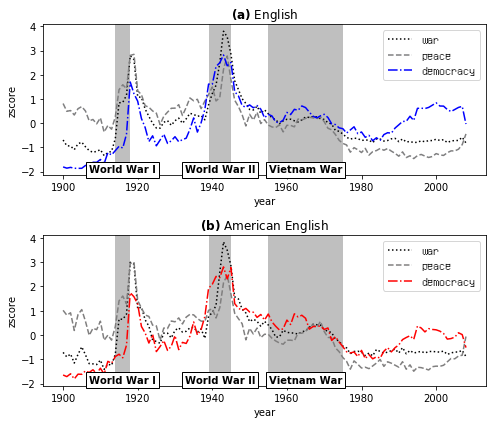

In [7]:
# example time series visualizations
ap_wp = [[[1914,1918],[1939,1945],[1955,1975]],
         ['World War I','World War II','Vietnam War']]
ngrams_wp = ['war','peace','democracy']
ngrams_linestyles_wp = [':','--','-.']
ngrams_markerstyles_wp = ['o','s','.']

fig, ax = plt.subplots(2,1,figsize=(7,3*2))
time_series(Z_eng,V_eng,
            ngrams_wp,
            ngrams_linestyles_wp,
            'blue',year_range,'year','zscore',
            title=r'$\mathbf{(a)}$ English',
            annotation=True,annotation_parameters=ap_wp,
            ax=ax[0])
time_series(Z_eng_us,V_eng_us,
               ngrams_wp,
               ngrams_linestyles_wp,
               'red',year_range,'year','zscore',
               title=r'$\mathbf{(b)}$ American English',
               annotation=True,annotation_parameters=ap_wp,
               ax=ax[1])
plt.tight_layout()
plt.show()

### 2. Time-Series Categorizations.

In [8]:
## Mann-Kendall test
def mk_test(x, alpha=0.001):
    """
    Credit: (see LICENCE)
    Created on Wed Jul 29 09:16:06 2015
    @author: Michael Schramm (Github)
    """
    n = len(x)
    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])
    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(x == unique_x[i])
            var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)
    if (z < 0) and h:
        trend = -1 #'decreasing'
    elif (z > 0) and h:
        trend = 1 #'increasing'
    else:
        trend = 0 #'no trend'
    return trend, h, p, z

In [9]:
# English (time-series categorizations)
start = time.time()
out = Parallel(n_jobs=3,backend='threading')(delayed(mk_test)(np.squeeze(np.array(Z_eng[w,:]))) for w in range(Z_eng.shape[0]))
ZT_eng = [0]*len(out)
for i, j in enumerate(out):
    ZT_eng[i] = j[0]
end = time.time()
print('English Time-series categorizations computing time: '+str(round(end-start,2))+' seconds.')

# American English (time-series categorizations)
start = time.time()
out = Parallel(n_jobs=3,backend='threading')(delayed(mk_test)(np.squeeze(np.array(Z_eng_us[w,:]))) for w in range(Z_eng_us.shape[0]))
ZT_eng_us = [0]*len(out)
for i, j in enumerate(out):
    ZT_eng_us[i] = j[0]
end = time.time()
print('American English Time-series categorizations computing time: '+str(round(end-start,2))+' seconds.')

English Time-series categorizations computing time: 176.76 seconds.
American English Time-series categorizations computing time: 156.12 seconds.


In [11]:
ztp = {'language': ['english','american-english'], 'vocabulary size (N)': [len(V_eng['forward'].keys()),len(V_eng_us['forward'].keys())],
       'decreasing rank (%)': [], 'irregular rank (%)': [], 'increasing rank (%)': []}
u, c = np.unique(ZT_eng,return_counts=True)
prop = np.round(c/c.sum(),4)
ztp['decreasing rank (%)'].append(prop[0])
ztp['irregular rank (%)'].append(prop[1])
ztp['increasing rank (%)'].append(prop[2])
u, c = np.unique(ZT_eng_us,return_counts=True)
prop = np.round(c/c.sum(),4)
ztp['decreasing rank (%)'].append(prop[0])
ztp['irregular rank (%)'].append(prop[1])
ztp['increasing rank (%)'].append(prop[2])
ztp = pd.DataFrame(ztp)
ztp = ztp.set_index('language')
ztp

,decreasing rank (%),increasing rank (%),irregular rank (%),vocabulary size (N)
language,,,,
english,0.4803,0.3572,0.1625,18737
american-english,0.4590,0.3581,0.1829,16410


### 3. Dynamic Mode Decomposition.

#### 3.1. Training DMD Matrix A.

In [229]:
# training time regimes (40,50,60,70,80,90) years
TR_train = 80 # years

### English dataset!
# step 1: extract training data
Z_eng_0 = Z_eng[:,0:TR_train]
Z_eng_1 = Z_eng[:,1:TR_train+1]

# step 2: compute SVD
U,S,VH = svd(Z_eng_0)

# step 3: compute inverted singular values (~99% of explained variance/normalized energy)
Sinv = np.zeros((TR_train,Z_eng.shape[0]),dtype=float)
Nsvals = 68
for j, i in enumerate(S[0:Nsvals]):
    Sinv[j,j]=1/i
    
# step 4: compute DMD matrix
A_eng = np.matmul( Z_eng_1, np.matmul( np.matmul( VH.conj().T, Sinv ), U.conj().T ) )
A_eng.shape

(18737, 18737)

#### 3.2. Testing DMD.

In [230]:
# reconstruct time-series using learned A
Z_eng_reco = np.matmul(A_eng,Z_eng_0) # matrix A multiplied by the original data

# test time-series beyond training limit using learned A
for t in range(0,Z_eng.shape[1]-TR_train):
    reco_next = np.matmul(A_eng,Z_eng_reco)
    Z_eng_reco = np.insert(Z_eng_reco,Z_eng_reco.shape[1],
                           reco_next[:,reco_next.shape[1]-1],axis=1)

# corrections (insert initial and delete last)
Z_eng_reco = np.insert(Z_eng_reco,0,Z_eng_0[:,0],axis=1)
Z_eng_reco = np.delete(Z_eng_reco,Z_eng_reco.shape[1]-1,axis=1)
Z_eng_reco.shape

(18737, 109)

In [231]:
index_wp = [V_eng['forward'][i] for i in ngrams_wp] # indices of the sample words

# organize sample words into a single matrix and vocabulary for plotting
sample_matrices = []
sample_vocabulary = {}
sample_vocabulary['forward'] = {}
indexer = 0
for j in index_wp:
    sample_matrices.append(Z_eng[j,:])
    sample_vocabulary['forward'][V_eng['reverse'][j]+' (original)'] = indexer
    indexer += 1
    sample_matrices.append(Z_eng_reco[j,:])
    sample_vocabulary['forward'][V_eng['reverse'][j]+' (reconstruction)'] = indexer
    indexer += 1
sample_matrices = np.matrix(sample_matrices)
sample_matrices.shape

(6, 109)

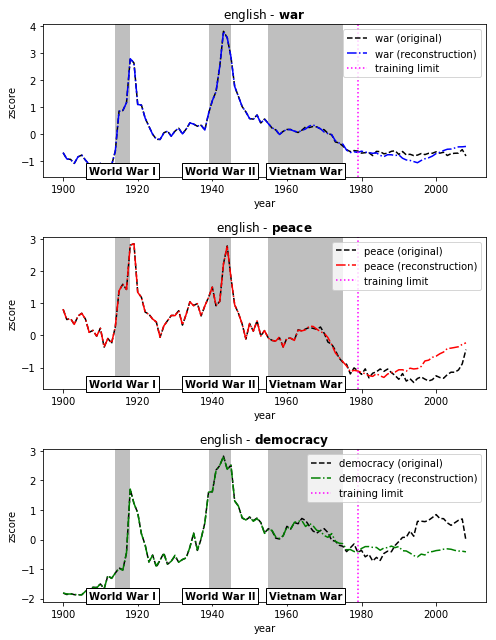

In [232]:
sample_ngrams_wp = list(sample_vocabulary['forward'].keys())
sample_ngrams_linestyles_wp = ['--','-.']
sample_ngrams_color = ['blue','red','green']

fig, ax = plt.subplots(len(ngrams_wp),1,figsize=(7,3*len(ngrams_wp)))
indexer = 0
for i, j in enumerate(ngrams_wp):
    time_series(sample_matrices,sample_vocabulary,
                sample_ngrams_wp[indexer:indexer+2],
                sample_ngrams_linestyles_wp,
                sample_ngrams_color[i],year_range,'year','zscore',
                title=r'english - $\mathbf{'+j+'}$',
                annotation=True,annotation_parameters=ap_wp,
                ax=ax[i])
    ax[i].axvline(year_range[TR_train-1],linestyle=':',color='magenta',label='training limit')
    ax[i].legend(loc=0)
    indexer += 2
plt.tight_layout()
plt.show()

### 4. Residuals.

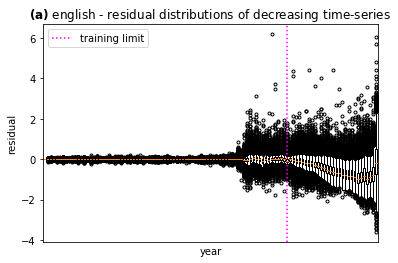

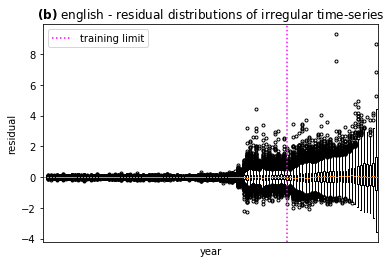

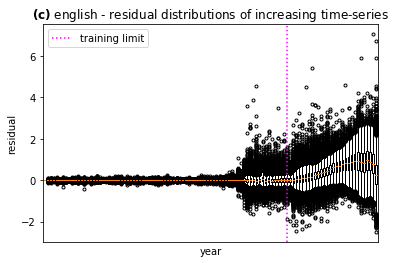

In [294]:
# compute residuals
R_eng = Z_eng-Z_eng_reco

# separate residuals by time-series category
R_eng_dec = R_eng[np.where(np.array(ZT_eng) == -1)[0],:]
R_eng_irr = R_eng[np.where(np.array(ZT_eng) ==  0)[0],:]
R_eng_inc = R_eng[np.where(np.array(ZT_eng) ==  1)[0],:]

plt.figure()
plt.boxplot(R_eng_dec,sym='.')
plt.axvline(TR_train,linestyle=':',color='magenta',label='training limit')
plt.xlabel('year')
plt.ylabel('residual')
plt.xticks([])
plt.title(r'$\mathbf{(a)}$ english - residual distributions of decreasing time-series')
plt.legend(loc=0)
plt.show()

plt.figure()
plt.boxplot(R_eng_irr,sym='.')
plt.axvline(TR_train,linestyle=':',color='magenta',label='training limit')
plt.xlabel('year')
plt.ylabel('residual')
plt.xticks([])
plt.title(r'$\mathbf{(b)}$ english - residual distributions of irregular time-series')
plt.legend(loc=0)
plt.show()

plt.figure()
plt.boxplot(R_eng_inc,sym='.')
plt.axvline(TR_train,linestyle=':',color='magenta',label='training limit')
plt.xlabel('year')
plt.ylabel('residual')
plt.xticks([])
plt.title(r'$\mathbf{(c)}$ english - residual distributions of increasing time-series')
plt.legend(loc=0)
plt.show()

The plots show that the distribution of residuals for each year have increasing variance or heteroskedastic residuals.